## ZBTCNN RL
**Reinforcement Learning Trading Bot**

Decides between buy/sell/stand given past and future price input

In [1]:
import os
import sys
import random
import time
from collections import deque
import pandas as pd
import numpy as np
from sklearn import preprocessing
from enum import Enum
import stable_baselines3
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.a2c.a2c import A2C
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import gym_anytrading
import json
import joblib
import matplotlib.pyplot as plt
import os

# CD to top level git directory
if ".git" not in os.listdir("."):
    os.chdir("../../")

# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [2]:
# Data parameters
SEQ_LEN = 48 #hours
FUTURE_PERIOD_PREDICT = 1 #hours

# Hyperparameter Optimizer parameters
# MAX_TRIALS = 40 # 10t x 20e ~ 4h

# Model parameters
# EPOCHS = 20
# BATCH_SIZE = 16
NAME = f"RL-SB3-{int(time.time())}"

In [3]:
## Import data
# DATA MUST BE FORMATTED USING CSV_FORMATTER.IPYNB

csv_file = "data/formatted/BTCUSDT-1h-data.csv"

data = pd.read_csv(csv_file, skiprows=[0], names=["timestamp", "open", "high", "low", "close", "volume", "rsi", "ema"])

data["Date"] = pd.to_datetime(data["timestamp"], unit="s")

data.drop(labels="timestamp", axis=1, inplace=True)

data.set_index("Date", inplace=True)



data.rename({"open": "Open", "high": "High", "low": "Low", "close": "Close", "volume": "Volume"}, axis=1, inplace=True)

data.head()

,Open,High,Low,Close,Volume,rsi,ema
Date,,,,,,,
2017-08-18 14:00:00,4304.15,4371.52,4296.04,4356.31,51.563675,52.623958,4327.151560
2017-08-18 15:00:00,4356.31,4357.37,4302.72,4340.31,24.093449,51.678528,4327.804777
2017-08-18 16:00:00,4320.52,4340.31,4287.79,4331.71,15.118957,51.167386,4327.995329
2017-08-18 17:00:00,4302.97,4318.16,4221.05,4293.09,46.533767,48.919621,4326.319858
2017-08-18 18:00:00,4293.09,4293.09,4193.70,4259.40,74.368943,47.054235,4323.157459


In [4]:
# Setup Bounds

train_bounds = (10000, 25000)
test_bounds = (25100, 38000)

info {'total_reward': 2141.00000000003, 'total_profit': 7.085645473238436e-25, 'position': 1}


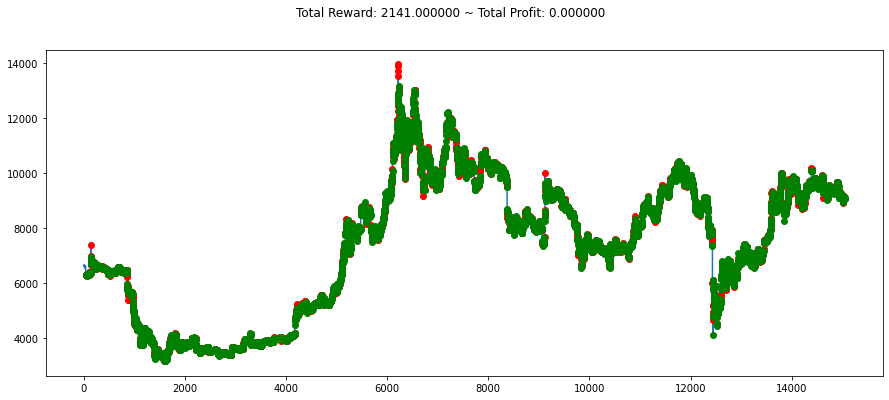

In [5]:
# Run env randomly

env = gym.make("stocks-v0", df=data, frame_bound=train_bounds, window_size=SEQ_LEN)

state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [6]:
# Auto env generation

train_env_factory = lambda: gym.make("stocks-v0", df=data, frame_bound=train_bounds, window_size=SEQ_LEN)
test_env_factory = lambda: gym.make("stocks-v0", df=data, frame_bound=test_bounds, window_size=SEQ_LEN)


train_env = DummyVecEnv([train_env_factory])
test_env = DummyVecEnv([test_env_factory])

In [7]:
# Callback

class cls_callback(BaseCallback):

    def __init__(self, verbose=0):
        super(cls_callback, self).__init__(verbose)

        print("Using cls_callback")

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        pass

    def _on_rollout_start(self) -> None:
        """
        A rollout is the collection of environment interaction
        using the current policy.
        This event is triggered before collecting new samples.
        """
        pass

    def _on_step(self) -> bool:
        """
        This method will be called by the model after each call to `env.step()`.

        For child callback (of an `EventCallback`), this will be called
        when the event is triggered.

        :return: (bool) If the callback returns False, training is aborted early.
        """
        os.system("clear")
        return True

    def _on_rollout_end(self) -> None:
        """
        This event is triggered before updating the policy.
        """
        pass

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        pass



In [8]:
# Make model

model = A2C("MlpPolicy", train_env, verbose=1, tensorboard_log=f"./logs/{NAME}")

Using cuda device


In [9]:
# Train model

# my_cls_callback = cls_callback()

model = model.learn(total_timesteps=300000, eval_env=test_env) #, callback=my_cls_callback)

Logging to ./logs/RL-SB3-1647131577/A2C_1
------------------------------------
| time/                 |          |
|    fps                | 441      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.692   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.351   |
|    value_loss         | 0.587    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 415      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.692   |
|    explained_variance | -0.00324 |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 4.15   

info {'total_reward': 0.0, 'total_profit': 1.0, 'position': 0}


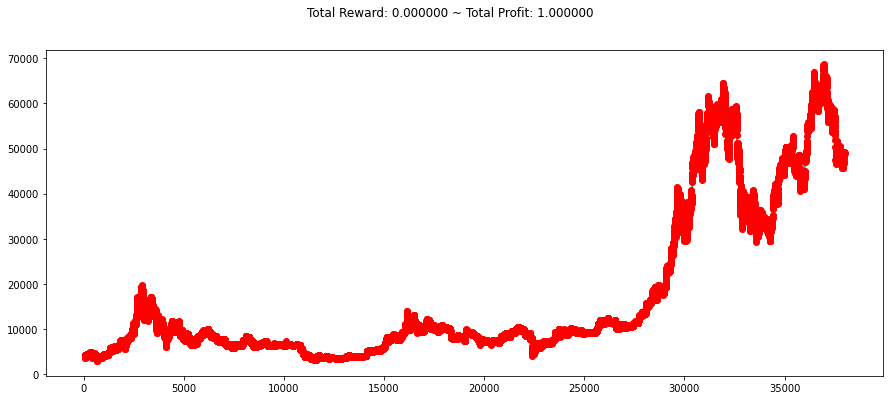

In [12]:
# Run env with model

env = gym.make("stocks-v0", df=data, frame_bound=(50,38000), window_size=SEQ_LEN)

state = env.reset()
while True: 
    action, *_ = model.predict(state)
    state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()